# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines Project** 
***
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm, grid_search
from skimage.feature import hog

import pickle
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from skimage import color
%matplotlib inline

/Users/Sukii/anaconda/envs/P1_python35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Sukii/anaconda/envs/P1_python35/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Bacis Function

In [118]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        #feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    print("spatial_features:", len(spatial_features))
    print("hist_features:", len(hist_features))
    print("hog_features:", len(hog_features))
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images

    file_features = []
    # Read in each one by one
    image = img
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    #feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    features.append(np.concatenate(file_features))
    # Return list of feature vectors
    #print("spatial_features:", len(spatial_features))
    #print("hist_features:", len(hist_features))
    #print("hog_features:", len(hog_features))
    return features
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        decision_value = clf.decision_function(test_features)
        #
        #7) If positive (prediction == 1) then save the window
        if prediction == 1 and decision_value > 0.6:
            on_windows.append(window)
            #print("decision_value:",decision_value)
    #8) Return windows for positive detections
    return on_windows

## Training Data Example

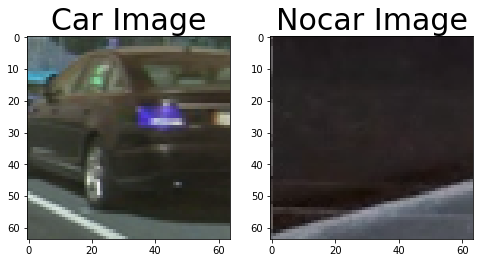

In [4]:
image_car = cv2.imread('vehicles/GTI_Right/image0003.png')
image_nocar = cv2.imread('non-vehicles/Extras/extra3.png')
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
ax1.imshow(image_car)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(image_nocar)
ax2.set_title('Nocar Image', fontsize=30)

f.savefig('./output_images/car_nocar.png') 

## HOG Classify

[ 0.04210801  0.00915513  0.00544787 ...,  0.00424939  0.00378469  0.        ]


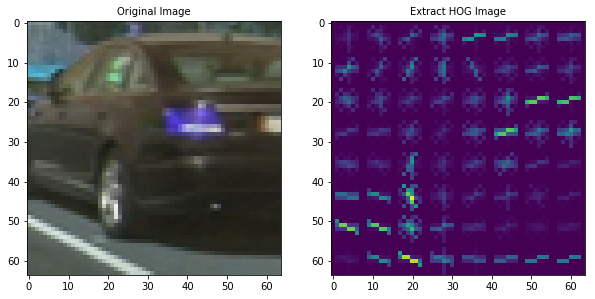

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

image_car_YUV = cv2.cvtColor(image_car, cv2.COLOR_RGB2YCrCb)
#image_car_gray = cv2.cvtColor(image_car_YUV, cv2.COLOR_RGB2GRAY)
features, image_car_hog = get_hog_features(image_car_YUV[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
print(features)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(image_car)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(image_car_hog)
ax2.set_title('Extract HOG Image', fontsize=10)

f.savefig('./output_images/car_HOG.png')


[ 0.04383832  0.01352136  0.00584321 ...,  0.00545253  0.00135354  0.        ]


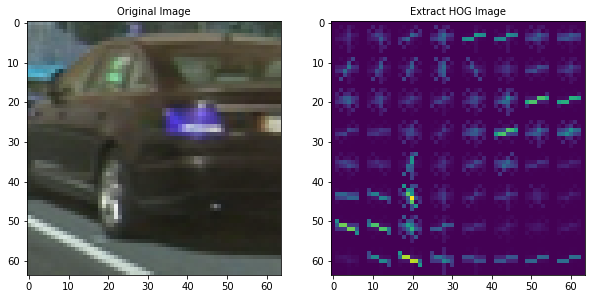

In [6]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

#image_car_YUV = cv2.cvtColor(image_car, cv2.COLOR_RGB2YUV)
#image_car_gray = cv2.cvtColor(image_car_YUV, cv2.COLOR_RGB2GRAY)
features, image_car_hog = get_hog_features(image_car[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
print(features)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(image_car)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(image_car_hog)
ax2.set_title('Extract HOG Image', fontsize=10)

#f.savefig('./output_images/car_HOG.png')


## Search and Classify

In [104]:
# Read in cars and notcars

cars_right = glob.glob('vehicles/GTI_Right/image****.png')
print("cars_right: ", len(cars_right))
cars_left = glob.glob('vehicles/GTI_Left/image****.png')
print("cars_left: ", len(cars_left))
cars_far = glob.glob('vehicles/GTI_Far/image****.png')
print("cars_far: ", len(cars_far))
GTI_MiddleClose = glob.glob('vehicles/GTI_MiddleClose/****.png')
print("GTI_MiddleClose: ", len(GTI_MiddleClose))
cars_extracted = glob.glob('vehicles/KITTI_extracted/****.png')
print("cars_extracted: ", len(cars_extracted))
notcars_extras = glob.glob('non-vehicles/Extras/extra****.png')
print("notcars_extras: ", len(notcars_extras))
notcars_GTI = glob.glob('non-vehicles/GTI/image****.png')
print("notcars_GTI: ", len(notcars_GTI))

cars = []
notcars = []
cars = cars_right + cars_left + cars_far + GTI_MiddleClose + cars_extracted 
notcars = notcars_GTI + notcars_extras   
print("Cars:", len(cars)," notcars:", len(notcars))
        
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 7600
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 256    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#y_start_stop = [400, 720] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(loss='hinge')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

cars_right:  664
cars_left:  909
cars_far:  834
GTI_MiddleClose:  419
cars_extracted:  5966
notcars_extras:  5068
notcars_GTI:  3900
Cars: 8792  notcars: 8968
spatial_features: 3072
hist_features: 768
hog_features: 2352
spatial_features: 3072
hist_features: 768
hog_features: 2352
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6192
6.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9882


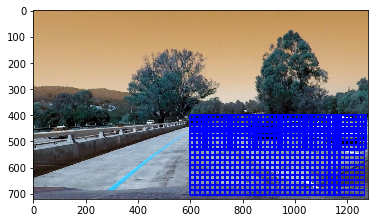

In [105]:
image = cv2.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows_1 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 528], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5))

windows_2 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 528], 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8))

windows_3 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 720], 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))

windows_4 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 720], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                    
windows =   windows_1 + windows_3    

windows_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
plt.imshow(windows_img)

plt.savefig('./output_images/slide_window.png')

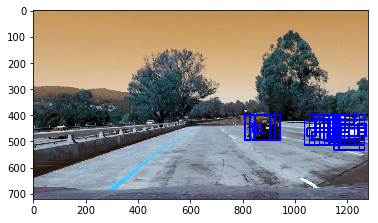

In [119]:
draw_image = image
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

plt.savefig('./output_images/slide_window_detect.png')

### Multiple Detections & False Positives

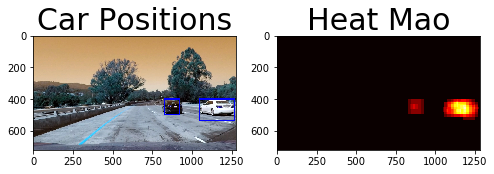

In [120]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = hot_windows

# Read in image similar to one shown above 
image = cv2.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
'''
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
'''

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=30)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Mao', fontsize=30)

f.savefig('./output_images/heat_map.png') 


In [121]:
def Vehicle_Detection(img): 

    image = img
    draw_image = np.copy(image)
    
    windows_1 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 528], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5))

    windows_2 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 528], 
                        xy_window=(64, 64), xy_overlap=(0.8, 0.8))

    windows_3 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 720], 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))

    windows_4 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 720], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

    windows =   windows_1 + windows_3

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    box_list = hot_windows

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

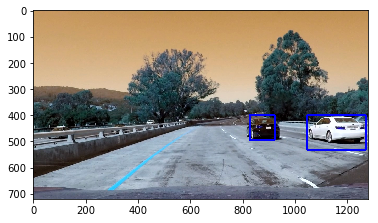

In [122]:
image_path_input = cv2.imread('test_images/test1.jpg')
output_image = Vehicle_Detection(image_path_input)
plt.imshow(output_image)

plt.savefig('./output_images/teat1_output.png') 

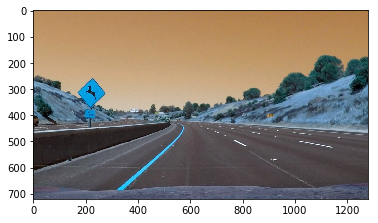

In [123]:
image_path_input = cv2.imread('test_images/test2.jpg')
output_image = Vehicle_Detection(image_path_input)
plt.imshow(output_image)

plt.savefig('./output_images/teat2_output.png') 

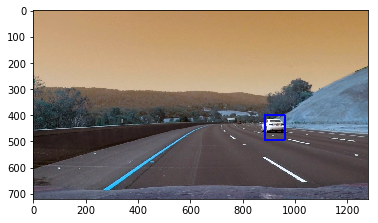

In [124]:
image_path_input = cv2.imread('test_images/test3.jpg')
output_image = Vehicle_Detection(image_path_input)
plt.imshow(output_image)

plt.savefig('./output_images/teat3_output.png') 

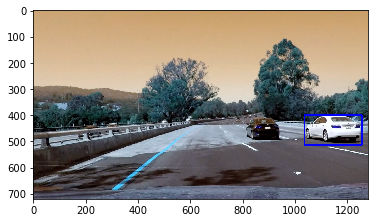

In [125]:
image_path_input = cv2.imread('test_images/test4.jpg')
output_image = Vehicle_Detection(image_path_input)
plt.imshow(output_image)

plt.savefig('./output_images/teat4_output.png') 

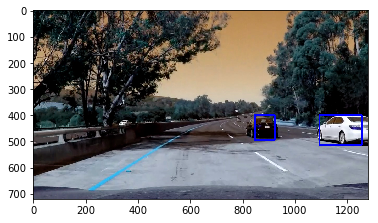

In [126]:
image_path_input = cv2.imread('test_images/test5.jpg')
output_image = Vehicle_Detection(image_path_input)
plt.imshow(output_image)

plt.savefig('./output_images/teat5_output.png') 

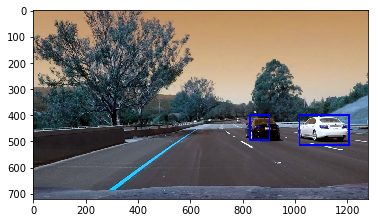

In [127]:
image_path_input = cv2.imread('test_images/test6.jpg')
output_image = Vehicle_Detection(image_path_input)
plt.imshow(output_image)

plt.savefig('./output_images/teat6_output.png') 

## Video

In [128]:
frame_window = []
frame_filter = 16
def Vehicle_Detection_video(img): 

    image = img
    draw_image = np.copy(image)
    
    windows_1 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 528], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5))

    windows_2 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 528], 
                        xy_window=(64, 64), xy_overlap=(0.8, 0.8))

    windows_3 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 720], 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))

    windows_4 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 720], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

    windows =   windows_1 + windows_3

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    frame_len = len(frame_window)
    hot_windows_frame = []
    
    if frame_len == 0:
        frame_window.append(hot_windows)
        hot_windows_frame = frame_window[0]
        print("stage 1:",frame_len)
    elif frame_len > 0 and frame_len <= frame_filter:
        frame_window.append(hot_windows)
        #hot_windows_frame = hot_windows
        for index in range(0,frame_len):
            hot_windows_frame = hot_windows_frame + frame_window[index] 
        print("stage 2:",frame_len)
    elif frame_len > frame_filter:
        frame_window.append(hot_windows)
        del frame_window[0]
        #print(hot_windows)
        for index in range(0,frame_len):
            hot_windows_frame = hot_windows_frame + frame_window[index]
        #print(hot_windows_frame)
        print("stage 3:",frame_len)
        
    window_img = draw_boxes(draw_image, hot_windows_frame, color=(0, 0, 255), thick=6)                    
    
    box_list = hot_windows_frame

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    if frame_len < frame_filter:
        heat = apply_threshold(heat,1)
    elif frame_len >= frame_filter:
        heat = apply_threshold(heat, frame_filter)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [129]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [130]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return Vehicle_Detection_video(image)

In [131]:
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(30,43)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

stage 1: 0
[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


  0%|          | 1/326 [00:01<07:02,  1.30s/it]

stage 2: 1


  1%|          | 2/326 [00:02<07:00,  1.30s/it]

stage 2: 2


  1%|          | 3/326 [00:03<06:57,  1.29s/it]

stage 2: 3


  1%|          | 4/326 [00:05<06:54,  1.29s/it]

stage 2: 4


  2%|▏         | 5/326 [00:06<06:52,  1.29s/it]

stage 2: 5


  2%|▏         | 6/326 [00:07<06:51,  1.28s/it]

stage 2: 6


  2%|▏         | 7/326 [00:09<06:50,  1.29s/it]

stage 2: 7


  2%|▏         | 8/326 [00:10<06:49,  1.29s/it]

stage 2: 8


  3%|▎         | 9/326 [00:11<06:48,  1.29s/it]

stage 2: 9


  3%|▎         | 10/326 [00:12<06:45,  1.28s/it]

stage 2: 10


  3%|▎         | 11/326 [00:14<06:44,  1.28s/it]

stage 2: 11


  4%|▎         | 12/326 [00:15<06:43,  1.28s/it]

stage 2: 12


  4%|▍         | 13/326 [00:16<06:47,  1.30s/it]

stage 2: 13


  4%|▍         | 14/326 [00:18<06:44,  1.30s/it]

stage 2: 14


  5%|▍         | 15/326 [00:19<06:42,  1.29s/it]

stage 2: 15


  5%|▍         | 16/326 [00:20<06:40,  1.29s/it]

stage 2: 16


  5%|▌         | 17/326 [00:21<06:38,  1.29s/it]

stage 3: 17


  6%|▌         | 18/326 [00:23<06:36,  1.29s/it]

stage 3: 17


  6%|▌         | 19/326 [00:24<06:35,  1.29s/it]

stage 3: 17


  6%|▌         | 20/326 [00:25<06:33,  1.28s/it]

stage 3: 17


  6%|▋         | 21/326 [00:27<06:31,  1.28s/it]

stage 3: 17


  7%|▋         | 22/326 [00:28<06:30,  1.28s/it]

stage 3: 17


  7%|▋         | 23/326 [00:29<06:28,  1.28s/it]

stage 3: 17


  7%|▋         | 24/326 [00:30<06:26,  1.28s/it]

stage 3: 17


  8%|▊         | 25/326 [00:32<06:26,  1.28s/it]

stage 3: 17


  8%|▊         | 26/326 [00:33<06:24,  1.28s/it]

stage 3: 17


  8%|▊         | 27/326 [00:34<06:23,  1.28s/it]

stage 3: 17


  9%|▊         | 28/326 [00:36<06:21,  1.28s/it]

stage 3: 17


  9%|▉         | 29/326 [00:37<06:20,  1.28s/it]

stage 3: 17


  9%|▉         | 30/326 [00:38<06:20,  1.29s/it]

stage 3: 17


 10%|▉         | 31/326 [00:39<06:22,  1.30s/it]

stage 3: 17


 10%|▉         | 32/326 [00:41<06:21,  1.30s/it]

stage 3: 17


 10%|█         | 33/326 [00:42<06:19,  1.29s/it]

stage 3: 17


 10%|█         | 34/326 [00:43<06:16,  1.29s/it]

stage 3: 17


 11%|█         | 35/326 [00:45<06:16,  1.29s/it]

stage 3: 17


 11%|█         | 36/326 [00:46<06:14,  1.29s/it]

stage 3: 17


 11%|█▏        | 37/326 [00:47<06:20,  1.32s/it]

stage 3: 17


 12%|█▏        | 38/326 [00:49<06:55,  1.44s/it]

stage 3: 17


 12%|█▏        | 39/326 [00:51<07:06,  1.49s/it]

stage 3: 17


 12%|█▏        | 40/326 [00:52<07:13,  1.52s/it]

stage 3: 17


 13%|█▎        | 41/326 [00:53<06:52,  1.45s/it]

stage 3: 17


 13%|█▎        | 42/326 [00:55<06:37,  1.40s/it]

stage 3: 17


 13%|█▎        | 43/326 [00:56<06:31,  1.38s/it]

stage 3: 17


 13%|█▎        | 44/326 [00:57<06:21,  1.35s/it]

stage 3: 17


 14%|█▍        | 45/326 [00:59<06:14,  1.33s/it]

stage 3: 17


 14%|█▍        | 46/326 [01:00<06:16,  1.34s/it]

stage 3: 17


 14%|█▍        | 47/326 [01:01<06:10,  1.33s/it]

stage 3: 17


 15%|█▍        | 48/326 [01:03<06:06,  1.32s/it]

stage 3: 17


 15%|█▌        | 49/326 [01:04<06:03,  1.31s/it]

stage 3: 17


 15%|█▌        | 50/326 [01:05<06:01,  1.31s/it]

stage 3: 17


 16%|█▌        | 51/326 [01:07<06:00,  1.31s/it]

stage 3: 17


 16%|█▌        | 52/326 [01:08<05:59,  1.31s/it]

stage 3: 17


 16%|█▋        | 53/326 [01:09<05:59,  1.32s/it]

stage 3: 17


 17%|█▋        | 54/326 [01:10<05:55,  1.31s/it]

stage 3: 17


 17%|█▋        | 55/326 [01:12<05:55,  1.31s/it]

stage 3: 17


 17%|█▋        | 56/326 [01:13<05:53,  1.31s/it]

stage 3: 17


 17%|█▋        | 57/326 [01:14<05:50,  1.30s/it]

stage 3: 17


 18%|█▊        | 58/326 [01:16<05:50,  1.31s/it]

stage 3: 17


 18%|█▊        | 59/326 [01:17<05:49,  1.31s/it]

stage 3: 17


 18%|█▊        | 60/326 [01:18<05:48,  1.31s/it]

stage 3: 17


 19%|█▊        | 61/326 [01:20<05:49,  1.32s/it]

stage 3: 17


 19%|█▉        | 62/326 [01:21<05:46,  1.31s/it]

stage 3: 17


 19%|█▉        | 63/326 [01:23<06:10,  1.41s/it]

stage 3: 17


 20%|█▉        | 64/326 [01:24<06:22,  1.46s/it]

stage 3: 17


 20%|█▉        | 65/326 [01:26<06:14,  1.44s/it]

stage 3: 17


 20%|██        | 66/326 [01:27<06:01,  1.39s/it]

stage 3: 17


 21%|██        | 67/326 [01:28<05:53,  1.37s/it]

stage 3: 17


 21%|██        | 68/326 [01:29<05:47,  1.35s/it]

stage 3: 17


 21%|██        | 69/326 [01:31<05:42,  1.33s/it]

stage 3: 17


 21%|██▏       | 70/326 [01:32<05:44,  1.34s/it]

stage 3: 17


 22%|██▏       | 71/326 [01:33<05:39,  1.33s/it]

stage 3: 17


 22%|██▏       | 72/326 [01:35<05:35,  1.32s/it]

stage 3: 17


 22%|██▏       | 73/326 [01:36<05:33,  1.32s/it]

stage 3: 17


 23%|██▎       | 74/326 [01:37<05:30,  1.31s/it]

stage 3: 17


 23%|██▎       | 75/326 [01:39<05:29,  1.31s/it]

stage 3: 17


 23%|██▎       | 76/326 [01:40<05:28,  1.31s/it]

stage 3: 17


 24%|██▎       | 77/326 [01:41<05:27,  1.32s/it]

stage 3: 17


 24%|██▍       | 78/326 [01:43<05:27,  1.32s/it]

stage 3: 17


 24%|██▍       | 79/326 [01:44<05:24,  1.31s/it]

stage 3: 17


 25%|██▍       | 80/326 [01:45<05:23,  1.31s/it]

stage 3: 17


 25%|██▍       | 81/326 [01:47<05:21,  1.31s/it]

stage 3: 17


 25%|██▌       | 82/326 [01:48<05:20,  1.31s/it]

stage 3: 17


 25%|██▌       | 83/326 [01:49<05:19,  1.31s/it]

stage 3: 17


 26%|██▌       | 84/326 [01:50<05:17,  1.31s/it]

stage 3: 17


 26%|██▌       | 85/326 [01:52<05:16,  1.31s/it]

stage 3: 17


 26%|██▋       | 86/326 [01:53<05:14,  1.31s/it]

stage 3: 17


 27%|██▋       | 87/326 [01:54<05:12,  1.31s/it]

stage 3: 17


 27%|██▋       | 88/326 [01:56<05:11,  1.31s/it]

stage 3: 17


 27%|██▋       | 89/326 [01:57<05:09,  1.31s/it]

stage 3: 17


 28%|██▊       | 90/326 [01:58<05:08,  1.31s/it]

stage 3: 17


 28%|██▊       | 91/326 [02:00<05:07,  1.31s/it]

stage 3: 17


 28%|██▊       | 92/326 [02:01<05:06,  1.31s/it]

stage 3: 17


 29%|██▊       | 93/326 [02:02<05:05,  1.31s/it]

stage 3: 17


 29%|██▉       | 94/326 [02:04<05:02,  1.30s/it]

stage 3: 17


 29%|██▉       | 95/326 [02:05<05:01,  1.30s/it]

stage 3: 17


 29%|██▉       | 96/326 [02:06<04:58,  1.30s/it]

stage 3: 17


 30%|██▉       | 97/326 [02:07<04:57,  1.30s/it]

stage 3: 17


 30%|███       | 98/326 [02:09<04:55,  1.30s/it]

stage 3: 17


 30%|███       | 99/326 [02:10<04:54,  1.30s/it]

stage 3: 17


 31%|███       | 100/326 [02:11<04:53,  1.30s/it]

stage 3: 17


 31%|███       | 101/326 [02:13<04:52,  1.30s/it]

stage 3: 17


 31%|███▏      | 102/326 [02:14<04:52,  1.30s/it]

stage 3: 17


 32%|███▏      | 103/326 [02:15<04:49,  1.30s/it]

stage 3: 17


 32%|███▏      | 104/326 [02:17<04:48,  1.30s/it]

stage 3: 17


 32%|███▏      | 105/326 [02:18<04:47,  1.30s/it]

stage 3: 17


 33%|███▎      | 106/326 [02:19<04:46,  1.30s/it]

stage 3: 17


 33%|███▎      | 107/326 [02:20<04:44,  1.30s/it]

stage 3: 17


 33%|███▎      | 108/326 [02:22<04:43,  1.30s/it]

stage 3: 17


 33%|███▎      | 109/326 [02:23<04:42,  1.30s/it]

stage 3: 17


 34%|███▎      | 110/326 [02:24<04:42,  1.31s/it]

stage 3: 17


 34%|███▍      | 111/326 [02:26<04:41,  1.31s/it]

stage 3: 17


 34%|███▍      | 112/326 [02:27<04:40,  1.31s/it]

stage 3: 17


 35%|███▍      | 113/326 [02:28<04:38,  1.31s/it]

stage 3: 17


 35%|███▍      | 114/326 [02:30<04:37,  1.31s/it]

stage 3: 17


 35%|███▌      | 115/326 [02:31<04:35,  1.31s/it]

stage 3: 17


 36%|███▌      | 116/326 [02:32<04:34,  1.31s/it]

stage 3: 17


 36%|███▌      | 117/326 [02:33<04:33,  1.31s/it]

stage 3: 17


 36%|███▌      | 118/326 [02:35<04:32,  1.31s/it]

stage 3: 17


 37%|███▋      | 119/326 [02:36<04:30,  1.31s/it]

stage 3: 17


 37%|███▋      | 120/326 [02:37<04:30,  1.31s/it]

stage 3: 17


 37%|███▋      | 121/326 [02:39<04:29,  1.31s/it]

stage 3: 17


 37%|███▋      | 122/326 [02:40<04:27,  1.31s/it]

stage 3: 17


 38%|███▊      | 123/326 [02:41<04:25,  1.31s/it]

stage 3: 17


 38%|███▊      | 124/326 [02:43<04:23,  1.31s/it]

stage 3: 17


 38%|███▊      | 125/326 [02:44<04:24,  1.31s/it]

stage 3: 17


 39%|███▊      | 126/326 [02:45<04:23,  1.32s/it]

stage 3: 17


 39%|███▉      | 127/326 [02:47<04:20,  1.31s/it]

stage 3: 17


 39%|███▉      | 128/326 [02:48<04:19,  1.31s/it]

stage 3: 17


 40%|███▉      | 129/326 [02:49<04:17,  1.31s/it]

stage 3: 17


 40%|███▉      | 130/326 [02:51<04:15,  1.30s/it]

stage 3: 17


 40%|████      | 131/326 [02:52<04:14,  1.30s/it]

stage 3: 17


 40%|████      | 132/326 [02:53<04:15,  1.32s/it]

stage 3: 17


 41%|████      | 133/326 [02:54<04:13,  1.31s/it]

stage 3: 17


 41%|████      | 134/326 [02:56<04:13,  1.32s/it]

stage 3: 17


 41%|████▏     | 135/326 [02:57<04:10,  1.31s/it]

stage 3: 17


 42%|████▏     | 136/326 [02:58<04:09,  1.31s/it]

stage 3: 17


 42%|████▏     | 137/326 [03:00<04:07,  1.31s/it]

stage 3: 17


 42%|████▏     | 138/326 [03:01<04:06,  1.31s/it]

stage 3: 17


 43%|████▎     | 139/326 [03:02<04:04,  1.31s/it]

stage 3: 17


 43%|████▎     | 140/326 [03:04<04:03,  1.31s/it]

stage 3: 17


 43%|████▎     | 141/326 [03:05<04:01,  1.31s/it]

stage 3: 17


 44%|████▎     | 142/326 [03:06<04:00,  1.31s/it]

stage 3: 17


 44%|████▍     | 143/326 [03:08<03:59,  1.31s/it]

stage 3: 17


 44%|████▍     | 144/326 [03:09<03:58,  1.31s/it]

stage 3: 17


 44%|████▍     | 145/326 [03:10<03:57,  1.31s/it]

stage 3: 17


 45%|████▍     | 146/326 [03:12<03:56,  1.32s/it]

stage 3: 17


 45%|████▌     | 147/326 [03:13<03:55,  1.31s/it]

stage 3: 17


 45%|████▌     | 148/326 [03:14<03:54,  1.32s/it]

stage 3: 17


 46%|████▌     | 149/326 [03:15<03:52,  1.31s/it]

stage 3: 17


 46%|████▌     | 150/326 [03:17<03:51,  1.32s/it]

stage 3: 17


 46%|████▋     | 151/326 [03:18<03:50,  1.32s/it]

stage 3: 17


 47%|████▋     | 152/326 [03:19<03:49,  1.32s/it]

stage 3: 17


 47%|████▋     | 153/326 [03:21<03:47,  1.32s/it]

stage 3: 17


 47%|████▋     | 154/326 [03:22<03:47,  1.32s/it]

stage 3: 17


 48%|████▊     | 155/326 [03:24<03:55,  1.38s/it]

stage 3: 17


 48%|████▊     | 156/326 [03:25<03:52,  1.37s/it]

stage 3: 17


 48%|████▊     | 157/326 [03:26<03:50,  1.37s/it]

stage 3: 17


 48%|████▊     | 158/326 [03:28<03:46,  1.35s/it]

stage 3: 17


 49%|████▉     | 159/326 [03:29<03:43,  1.34s/it]

stage 3: 17


 49%|████▉     | 160/326 [03:30<03:41,  1.33s/it]

stage 3: 17


 49%|████▉     | 161/326 [03:32<03:39,  1.33s/it]

stage 3: 17


 50%|████▉     | 162/326 [03:33<03:37,  1.32s/it]

stage 3: 17


 50%|█████     | 163/326 [03:34<03:34,  1.32s/it]

stage 3: 17


 50%|█████     | 164/326 [03:35<03:33,  1.32s/it]

stage 3: 17


 51%|█████     | 165/326 [03:37<03:32,  1.32s/it]

stage 3: 17


 51%|█████     | 166/326 [03:38<03:30,  1.31s/it]

stage 3: 17


 51%|█████     | 167/326 [03:39<03:30,  1.32s/it]

stage 3: 17


 52%|█████▏    | 168/326 [03:41<03:28,  1.32s/it]

stage 3: 17


 52%|█████▏    | 169/326 [03:42<03:26,  1.32s/it]

stage 3: 17


 52%|█████▏    | 170/326 [03:43<03:25,  1.32s/it]

stage 3: 17


 52%|█████▏    | 171/326 [03:45<03:23,  1.32s/it]

stage 3: 17


 53%|█████▎    | 172/326 [03:46<03:22,  1.32s/it]

stage 3: 17


 53%|█████▎    | 173/326 [03:47<03:20,  1.31s/it]

stage 3: 17


 53%|█████▎    | 174/326 [03:49<03:19,  1.31s/it]

stage 3: 17


 54%|█████▎    | 175/326 [03:50<03:18,  1.31s/it]

stage 3: 17


 54%|█████▍    | 176/326 [03:51<03:18,  1.32s/it]

stage 3: 17


 54%|█████▍    | 177/326 [03:53<03:16,  1.32s/it]

stage 3: 17


 55%|█████▍    | 178/326 [03:54<03:14,  1.32s/it]

stage 3: 17


 55%|█████▍    | 179/326 [03:55<03:13,  1.31s/it]

stage 3: 17


 55%|█████▌    | 180/326 [03:57<03:12,  1.32s/it]

stage 3: 17


 56%|█████▌    | 181/326 [03:58<03:11,  1.32s/it]

stage 3: 17


 56%|█████▌    | 182/326 [03:59<03:10,  1.32s/it]

stage 3: 17


 56%|█████▌    | 183/326 [04:00<03:08,  1.32s/it]

stage 3: 17


 56%|█████▋    | 184/326 [04:02<03:06,  1.31s/it]

stage 3: 17


 57%|█████▋    | 185/326 [04:03<03:05,  1.31s/it]

stage 3: 17


 57%|█████▋    | 186/326 [04:04<03:04,  1.32s/it]

stage 3: 17


 57%|█████▋    | 187/326 [04:06<03:02,  1.31s/it]

stage 3: 17


 58%|█████▊    | 188/326 [04:07<03:00,  1.31s/it]

stage 3: 17


 58%|█████▊    | 189/326 [04:08<02:59,  1.31s/it]

stage 3: 17


 58%|█████▊    | 190/326 [04:10<02:59,  1.32s/it]

stage 3: 17


 59%|█████▊    | 191/326 [04:11<02:57,  1.31s/it]

stage 3: 17


 59%|█████▉    | 192/326 [04:12<02:56,  1.31s/it]

stage 3: 17


 59%|█████▉    | 193/326 [04:14<02:54,  1.31s/it]

stage 3: 17


 60%|█████▉    | 194/326 [04:15<02:53,  1.32s/it]

stage 3: 17


 60%|█████▉    | 195/326 [04:16<02:52,  1.31s/it]

stage 3: 17


 60%|██████    | 196/326 [04:18<02:51,  1.32s/it]

stage 3: 17


 60%|██████    | 197/326 [04:19<02:49,  1.32s/it]

stage 3: 17


 61%|██████    | 198/326 [04:20<02:48,  1.32s/it]

stage 3: 17


 61%|██████    | 199/326 [04:22<02:46,  1.31s/it]

stage 3: 17


 61%|██████▏   | 200/326 [04:23<02:46,  1.32s/it]

stage 3: 17


 62%|██████▏   | 201/326 [04:24<02:45,  1.32s/it]

stage 3: 17


 62%|██████▏   | 202/326 [04:26<02:43,  1.32s/it]

stage 3: 17


 62%|██████▏   | 203/326 [04:27<02:42,  1.32s/it]

stage 3: 17


 63%|██████▎   | 204/326 [04:28<02:41,  1.32s/it]

stage 3: 17


 63%|██████▎   | 205/326 [04:29<02:40,  1.32s/it]

stage 3: 17


 63%|██████▎   | 206/326 [04:31<02:39,  1.33s/it]

stage 3: 17


 63%|██████▎   | 207/326 [04:32<02:37,  1.33s/it]

stage 3: 17


 64%|██████▍   | 208/326 [04:33<02:36,  1.33s/it]

stage 3: 17


 64%|██████▍   | 209/326 [04:35<02:35,  1.33s/it]

stage 3: 17


 64%|██████▍   | 210/326 [04:36<02:34,  1.33s/it]

stage 3: 17


 65%|██████▍   | 211/326 [04:37<02:33,  1.33s/it]

stage 3: 17


 65%|██████▌   | 212/326 [04:39<02:31,  1.33s/it]

stage 3: 17


 65%|██████▌   | 213/326 [04:40<02:30,  1.33s/it]

stage 3: 17


 66%|██████▌   | 214/326 [04:41<02:28,  1.33s/it]

stage 3: 17


 66%|██████▌   | 215/326 [04:43<02:27,  1.33s/it]

stage 3: 17


 66%|██████▋   | 216/326 [04:44<02:25,  1.32s/it]

stage 3: 17


 67%|██████▋   | 217/326 [04:45<02:24,  1.32s/it]

stage 3: 17


 67%|██████▋   | 218/326 [04:47<02:23,  1.33s/it]

stage 3: 17


 67%|██████▋   | 219/326 [04:48<02:21,  1.33s/it]

stage 3: 17


 67%|██████▋   | 220/326 [04:49<02:21,  1.33s/it]

stage 3: 17


 68%|██████▊   | 221/326 [04:51<02:19,  1.33s/it]

stage 3: 17


 68%|██████▊   | 222/326 [04:52<02:18,  1.33s/it]

stage 3: 17


 68%|██████▊   | 223/326 [04:54<02:22,  1.38s/it]

stage 3: 17


 69%|██████▊   | 224/326 [04:55<02:19,  1.37s/it]

stage 3: 17


 69%|██████▉   | 225/326 [04:56<02:16,  1.35s/it]

stage 3: 17


 69%|██████▉   | 226/326 [04:58<02:14,  1.34s/it]

stage 3: 17


 70%|██████▉   | 227/326 [04:59<02:12,  1.34s/it]

stage 3: 17


 70%|██████▉   | 228/326 [05:00<02:10,  1.33s/it]

stage 3: 17


 70%|███████   | 229/326 [05:02<02:08,  1.33s/it]

stage 3: 17


 71%|███████   | 230/326 [05:03<02:07,  1.32s/it]

stage 3: 17


 71%|███████   | 231/326 [05:04<02:05,  1.32s/it]

stage 3: 17


 71%|███████   | 232/326 [05:05<02:03,  1.32s/it]

stage 3: 17


 71%|███████▏  | 233/326 [05:07<02:02,  1.31s/it]

stage 3: 17


 72%|███████▏  | 234/326 [05:08<02:01,  1.32s/it]

stage 3: 17


 72%|███████▏  | 235/326 [05:09<01:59,  1.32s/it]

stage 3: 17


 72%|███████▏  | 236/326 [05:11<01:58,  1.32s/it]

stage 3: 17


 73%|███████▎  | 237/326 [05:12<01:57,  1.32s/it]

stage 3: 17


 73%|███████▎  | 238/326 [05:13<01:55,  1.32s/it]

stage 3: 17


 73%|███████▎  | 239/326 [05:15<01:54,  1.31s/it]

stage 3: 17


 74%|███████▎  | 240/326 [05:16<01:52,  1.31s/it]

stage 3: 17


 74%|███████▍  | 241/326 [05:17<01:51,  1.31s/it]

stage 3: 17


 74%|███████▍  | 242/326 [05:19<01:50,  1.32s/it]

stage 3: 17


 75%|███████▍  | 243/326 [05:20<01:49,  1.32s/it]

stage 3: 17


 75%|███████▍  | 244/326 [05:21<01:48,  1.32s/it]

stage 3: 17


 75%|███████▌  | 245/326 [05:23<01:47,  1.32s/it]

stage 3: 17


 75%|███████▌  | 246/326 [05:24<01:51,  1.40s/it]

stage 3: 17


 76%|███████▌  | 247/326 [05:25<01:49,  1.38s/it]

stage 3: 17


 76%|███████▌  | 248/326 [05:27<01:47,  1.38s/it]

stage 3: 17


 76%|███████▋  | 249/326 [05:28<01:44,  1.36s/it]

stage 3: 17


 77%|███████▋  | 250/326 [05:29<01:42,  1.35s/it]

stage 3: 17


 77%|███████▋  | 251/326 [05:31<01:40,  1.34s/it]

stage 3: 17


 77%|███████▋  | 252/326 [05:32<01:39,  1.34s/it]

stage 3: 17


 78%|███████▊  | 253/326 [05:33<01:37,  1.34s/it]

stage 3: 17


 78%|███████▊  | 254/326 [05:35<01:36,  1.33s/it]

stage 3: 17


 78%|███████▊  | 255/326 [05:36<01:34,  1.34s/it]

stage 3: 17


 79%|███████▊  | 256/326 [05:37<01:33,  1.34s/it]

stage 3: 17


 79%|███████▉  | 257/326 [05:39<01:32,  1.34s/it]

stage 3: 17


 79%|███████▉  | 258/326 [05:40<01:30,  1.34s/it]

stage 3: 17


 79%|███████▉  | 259/326 [05:41<01:29,  1.33s/it]

stage 3: 17


 80%|███████▉  | 260/326 [05:43<01:27,  1.33s/it]

stage 3: 17


 80%|████████  | 261/326 [05:44<01:26,  1.33s/it]

stage 3: 17


 80%|████████  | 262/326 [05:45<01:25,  1.33s/it]

stage 3: 17


 81%|████████  | 263/326 [05:47<01:23,  1.33s/it]

stage 3: 17


 81%|████████  | 264/326 [05:48<01:22,  1.34s/it]

stage 3: 17


 81%|████████▏ | 265/326 [05:49<01:21,  1.33s/it]

stage 3: 17


 82%|████████▏ | 266/326 [05:51<01:19,  1.33s/it]

stage 3: 17


 82%|████████▏ | 267/326 [05:52<01:18,  1.33s/it]

stage 3: 17


 82%|████████▏ | 268/326 [05:53<01:17,  1.33s/it]

stage 3: 17


 83%|████████▎ | 269/326 [05:55<01:15,  1.32s/it]

stage 3: 17


 83%|████████▎ | 270/326 [05:56<01:14,  1.33s/it]

stage 3: 17


 83%|████████▎ | 271/326 [05:57<01:12,  1.32s/it]

stage 3: 17


 83%|████████▎ | 272/326 [05:59<01:11,  1.32s/it]

stage 3: 17


 84%|████████▎ | 273/326 [06:00<01:09,  1.32s/it]

stage 3: 17


 84%|████████▍ | 274/326 [06:01<01:08,  1.32s/it]

stage 3: 17


 84%|████████▍ | 275/326 [06:03<01:07,  1.32s/it]

stage 3: 17


 85%|████████▍ | 276/326 [06:04<01:05,  1.32s/it]

stage 3: 17


 85%|████████▍ | 277/326 [06:05<01:04,  1.32s/it]

stage 3: 17


 85%|████████▌ | 278/326 [06:07<01:03,  1.31s/it]

stage 3: 17


 86%|████████▌ | 279/326 [06:08<01:01,  1.31s/it]

stage 3: 17


 86%|████████▌ | 280/326 [06:09<01:00,  1.32s/it]

stage 3: 17


 86%|████████▌ | 281/326 [06:11<00:59,  1.32s/it]

stage 3: 17


 87%|████████▋ | 282/326 [06:12<00:57,  1.31s/it]

stage 3: 17


 87%|████████▋ | 283/326 [06:13<00:56,  1.32s/it]

stage 3: 17


 87%|████████▋ | 284/326 [06:15<00:55,  1.32s/it]

stage 3: 17


 87%|████████▋ | 285/326 [06:16<00:53,  1.32s/it]

stage 3: 17


 88%|████████▊ | 286/326 [06:17<00:52,  1.32s/it]

stage 3: 17


 88%|████████▊ | 287/326 [06:18<00:51,  1.31s/it]

stage 3: 17


 88%|████████▊ | 288/326 [06:20<00:49,  1.31s/it]

stage 3: 17


 89%|████████▊ | 289/326 [06:21<00:48,  1.32s/it]

stage 3: 17


 89%|████████▉ | 290/326 [06:23<00:49,  1.38s/it]

stage 3: 17


 89%|████████▉ | 291/326 [06:24<00:47,  1.36s/it]

stage 3: 17


 90%|████████▉ | 292/326 [06:25<00:45,  1.35s/it]

stage 3: 17


 90%|████████▉ | 293/326 [06:27<00:44,  1.34s/it]

stage 3: 17


 90%|█████████ | 294/326 [06:28<00:42,  1.33s/it]

stage 3: 17


 90%|█████████ | 295/326 [06:29<00:41,  1.33s/it]

stage 3: 17


 91%|█████████ | 296/326 [06:31<00:39,  1.32s/it]

stage 3: 17


 91%|█████████ | 297/326 [06:32<00:38,  1.31s/it]

stage 3: 17


 91%|█████████▏| 298/326 [06:33<00:36,  1.31s/it]

stage 3: 17


 92%|█████████▏| 299/326 [06:34<00:35,  1.31s/it]

stage 3: 17


 92%|█████████▏| 300/326 [06:36<00:34,  1.31s/it]

stage 3: 17


 92%|█████████▏| 301/326 [06:37<00:32,  1.31s/it]

stage 3: 17


 93%|█████████▎| 302/326 [06:38<00:31,  1.31s/it]

stage 3: 17


 93%|█████████▎| 303/326 [06:40<00:30,  1.31s/it]

stage 3: 17


 93%|█████████▎| 304/326 [06:41<00:28,  1.31s/it]

stage 3: 17


 94%|█████████▎| 305/326 [06:42<00:27,  1.32s/it]

stage 3: 17


 94%|█████████▍| 306/326 [06:44<00:26,  1.32s/it]

stage 3: 17


 94%|█████████▍| 307/326 [06:45<00:25,  1.32s/it]

stage 3: 17


 94%|█████████▍| 308/326 [06:46<00:23,  1.31s/it]

stage 3: 17


 95%|█████████▍| 309/326 [06:48<00:22,  1.32s/it]

stage 3: 17


 95%|█████████▌| 310/326 [06:49<00:21,  1.32s/it]

stage 3: 17


 95%|█████████▌| 311/326 [06:50<00:19,  1.33s/it]

stage 3: 17


 96%|█████████▌| 312/326 [06:52<00:18,  1.33s/it]

stage 3: 17


 96%|█████████▌| 313/326 [06:53<00:17,  1.33s/it]

stage 3: 17


 96%|█████████▋| 314/326 [06:54<00:15,  1.32s/it]

stage 3: 17


 97%|█████████▋| 315/326 [06:56<00:14,  1.33s/it]

stage 3: 17


 97%|█████████▋| 316/326 [06:57<00:13,  1.33s/it]

stage 3: 17


 97%|█████████▋| 317/326 [06:58<00:11,  1.33s/it]

stage 3: 17


 98%|█████████▊| 318/326 [07:00<00:10,  1.33s/it]

stage 3: 17


 98%|█████████▊| 319/326 [07:01<00:09,  1.33s/it]

stage 3: 17


 98%|█████████▊| 320/326 [07:02<00:07,  1.33s/it]

stage 3: 17


 98%|█████████▊| 321/326 [07:04<00:06,  1.32s/it]

stage 3: 17


 99%|█████████▉| 322/326 [07:05<00:05,  1.33s/it]

stage 3: 17


 99%|█████████▉| 323/326 [07:06<00:03,  1.33s/it]

stage 3: 17


 99%|█████████▉| 324/326 [07:07<00:02,  1.33s/it]

stage 3: 17


100%|█████████▉| 325/326 [07:09<00:01,  1.33s/it]

stage 3: 17


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 13min 36s, sys: 8.88 s, total: 13min 45s
Wall time: 7min 10s


In [132]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_result.mp4"))
